# Dogs vs Cats (TF 2.7 -softmax)
**End to End Image Classification project using TensorFlow**

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/cat_dog.gif" width="750" align="center">

In [1]:
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D,Flatten,Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam,Adadelta,RMSprop,SGD
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import matplotlib.pyplot as plt
import numpy as np

## Organize data OLD SCHOOL!

In [2]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip --qq cats_and_dogs_filtered.zip

--2024-01-21 13:37:51--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   103MB/s    in 0.6s    

2024-01-21 13:37:52 (103 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
!pip install split_folders

## Splitting folders
We will split the input in 3 different dataset: train, val, test

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/splitting_folder.png" width="450" align="center">

In [4]:
import splitfolders
input_folder = 'cats_and_dogs_filtered/train/'
output_folder = 'data/'

In [5]:
splitfolders.ratio(input_folder,output_folder,seed=667,ratio=(.6,.2,.2))

Copying files: 2000 files [00:00, 2635.22 files/s]


In [6]:
img_height, img_width = (150,150)
batch_size = 10

train_data_dir = 'data/train'
validation_data_dir = 'data/val'
test_data_dir = 'data/test'

## NEW WAY TF2.7 (all classes divided inside subfolders)

In [7]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/dogs_cats_all.zip
!unzip --qq dogs_cats_all.zip

--2024-01-21 13:38:14--  https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/dogs_cats_all.zip
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.148.182, 3.5.245.136, 52.95.191.54, ...
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.148.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68391667 (65M) [application/octet-stream]
Saving to: ‘dogs_cats_all.zip’

dogs_cats_all.zip   100%[===================>]  65.22M  15.8MB/s    in 4.1s    

2024-01-21 13:38:19 (15.8 MB/s) - ‘dogs_cats_all.zip’ saved [68391667/68391667]




<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/augmentation.png" width="800" align="center">

In [8]:
dataset = 'dogs_cats_all'

image_size = (150, 150)
batch_size = 32
ch=3


In [9]:
training_set = image_dataset_from_directory(dataset,
                                            validation_split=0.2,
                                            subset="training",
                                            seed=667,
                                            image_size=image_size,
                                            batch_size=batch_size,
                                            label_mode = 'categorical'
                                            )

validation_set = image_dataset_from_directory(dataset,
                                              validation_split=0.2,
                                              subset="validation",
                                              seed=667,
                                              image_size=image_size,
                                              batch_size=batch_size,
                                              label_mode = 'categorical'
                                              )

Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Found 3000 files belonging to 2 classes.
Using 600 files for validation.


In [10]:
class_names = training_set.class_names
class_names

['cats', 'dogs']

In [11]:
num_classes = len(class_names)
num_classes

2

In [12]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))

#output with 2 neurons, so we can apply softmax
model.add(Dense(2, activation='softmax'))

# compile model
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 128)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 128)       0

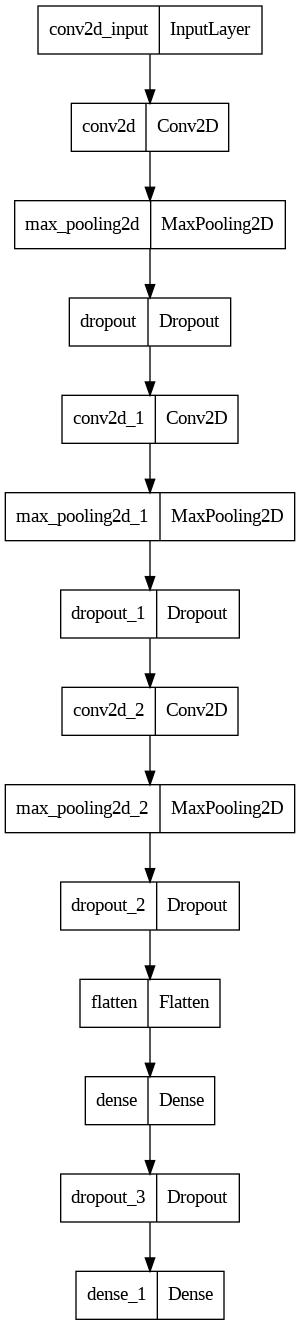

In [14]:
plot_model(model)

In [15]:
file_path="weights_best.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
callbacks_list = [checkpoint, early] #early

history = model.fit(training_set,
                    validation_data=validation_set,
                    epochs=10,
                    #steps_per_epoch=len(training_set),
                    #validation_steps=len(validation_set),
                    callbacks=callbacks_list
                    )

Epoch 1/10
75/75 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4983
Epoch 1: val_accuracy improved from -inf to 0.50833, saving model to weights_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - 19s 117ms/step - loss: nan - accuracy: 0.4983 - val_loss: nan - val_accuracy: 0.5083
Epoch 2/10
75/75 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4979
Epoch 2: val_accuracy did not improve from 0.50833
75/75 [==============================] - 8s 98ms/step - loss: nan - accuracy: 0.4979 - val_loss: nan - val_accuracy: 0.5083
Epoch 3/10
75/75 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4979
Epoch 3: val_accuracy did not improve from 0.50833
75/75 [==============================] - 6s 74ms/step - loss: nan - accuracy: 0.4979 - val_loss: nan - val_accuracy: 0.5083
Epoch 4/10
75/75 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4979
Epoch 4: val_accuracy did not improve from 0.50833
75/75 [==============================] - 6s 73ms/step - loss: nan - accuracy: 0.4979 - val_loss: nan - val_accuracy: 0.5083
Epoch 5/10
75/75 [==============================] - ETA: 0s - loss: nan - ac

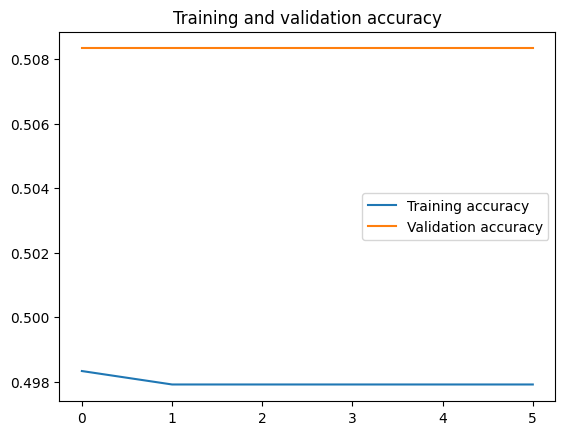

In [16]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

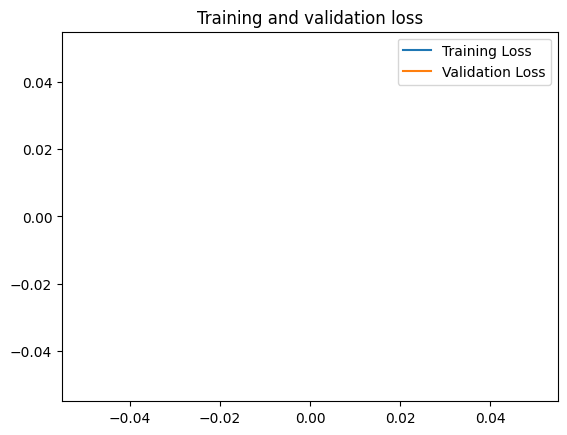

In [17]:
plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [18]:
# Struttura della nostra Neural Network
model =Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu'))

# Output layer - Number neuron == number classes
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 128)      

In [20]:
file_path="weights_best.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
callbacks_list = [checkpoint, early] #early

history = model.fit(training_set,
                    validation_data=validation_set,
                    epochs=10,
                    #steps_per_epoch=len(training_set),
                    #validation_steps=len(validation_set),
                    callbacks=callbacks_list
                    )

Epoch 1/10
74/75 [============================>.] - ETA: 0s - loss: 7.8959 - accuracy: 0.4907
Epoch 1: val_accuracy improved from -inf to 0.54833, saving model to weights_best.h5
75/75 [==============================] - 9s 62ms/step - loss: 7.7996 - accuracy: 0.4925 - val_loss: 0.6857 - val_accuracy: 0.5483
Epoch 2/10
74/75 [============================>.] - ETA: 0s - loss: 0.6908 - accuracy: 0.5220
Epoch 2: val_accuracy did not improve from 0.54833
75/75 [==============================] - 4s 46ms/step - loss: 0.6907 - accuracy: 0.5217 - val_loss: 0.6773 - val_accuracy: 0.5383
Epoch 3/10
75/75 [==============================] - ETA: 0s - loss: 0.6854 - accuracy: 0.5350
Epoch 3: val_accuracy improved from 0.54833 to 0.59667, saving model to weights_best.h5
75/75 [==============================] - 5s 63ms/step - loss: 0.6854 - accuracy: 0.5350 - val_loss: 0.6713 - val_accuracy: 0.5967
Epoch 4/10
75/75 [==============================] - ETA: 0s - loss: 0.6681 - accuracy: 0.5958
Epoch 4: v

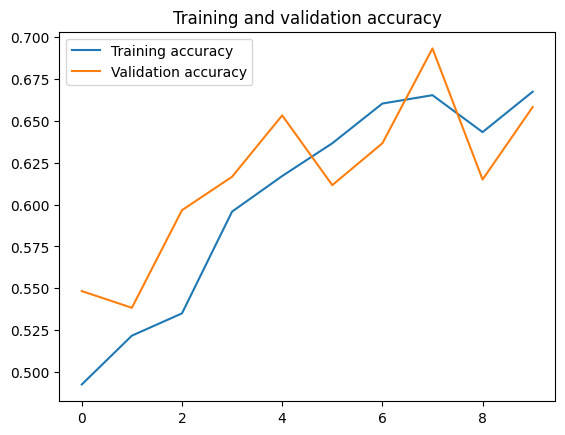

In [21]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

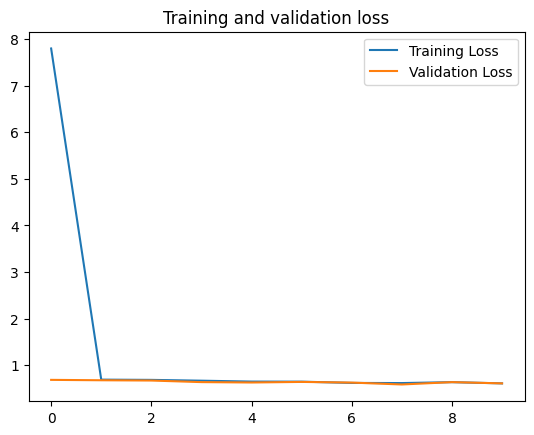

In [22]:
plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [23]:
model.save('dog_cat_finetuned.h5')

In [24]:
model = load_model('dog_cat_finetuned.h5')

In [25]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

prediction_classes = np.array([])
true_classes =  np.array([])

for x, y in validation_set:
    prediction_classes = np.concatenate([prediction_classes,np.argmax(model.predict(x), axis = -1)])
    true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])

1/1 [==============================] - 0s 84ms/step


## Print first 50 observation

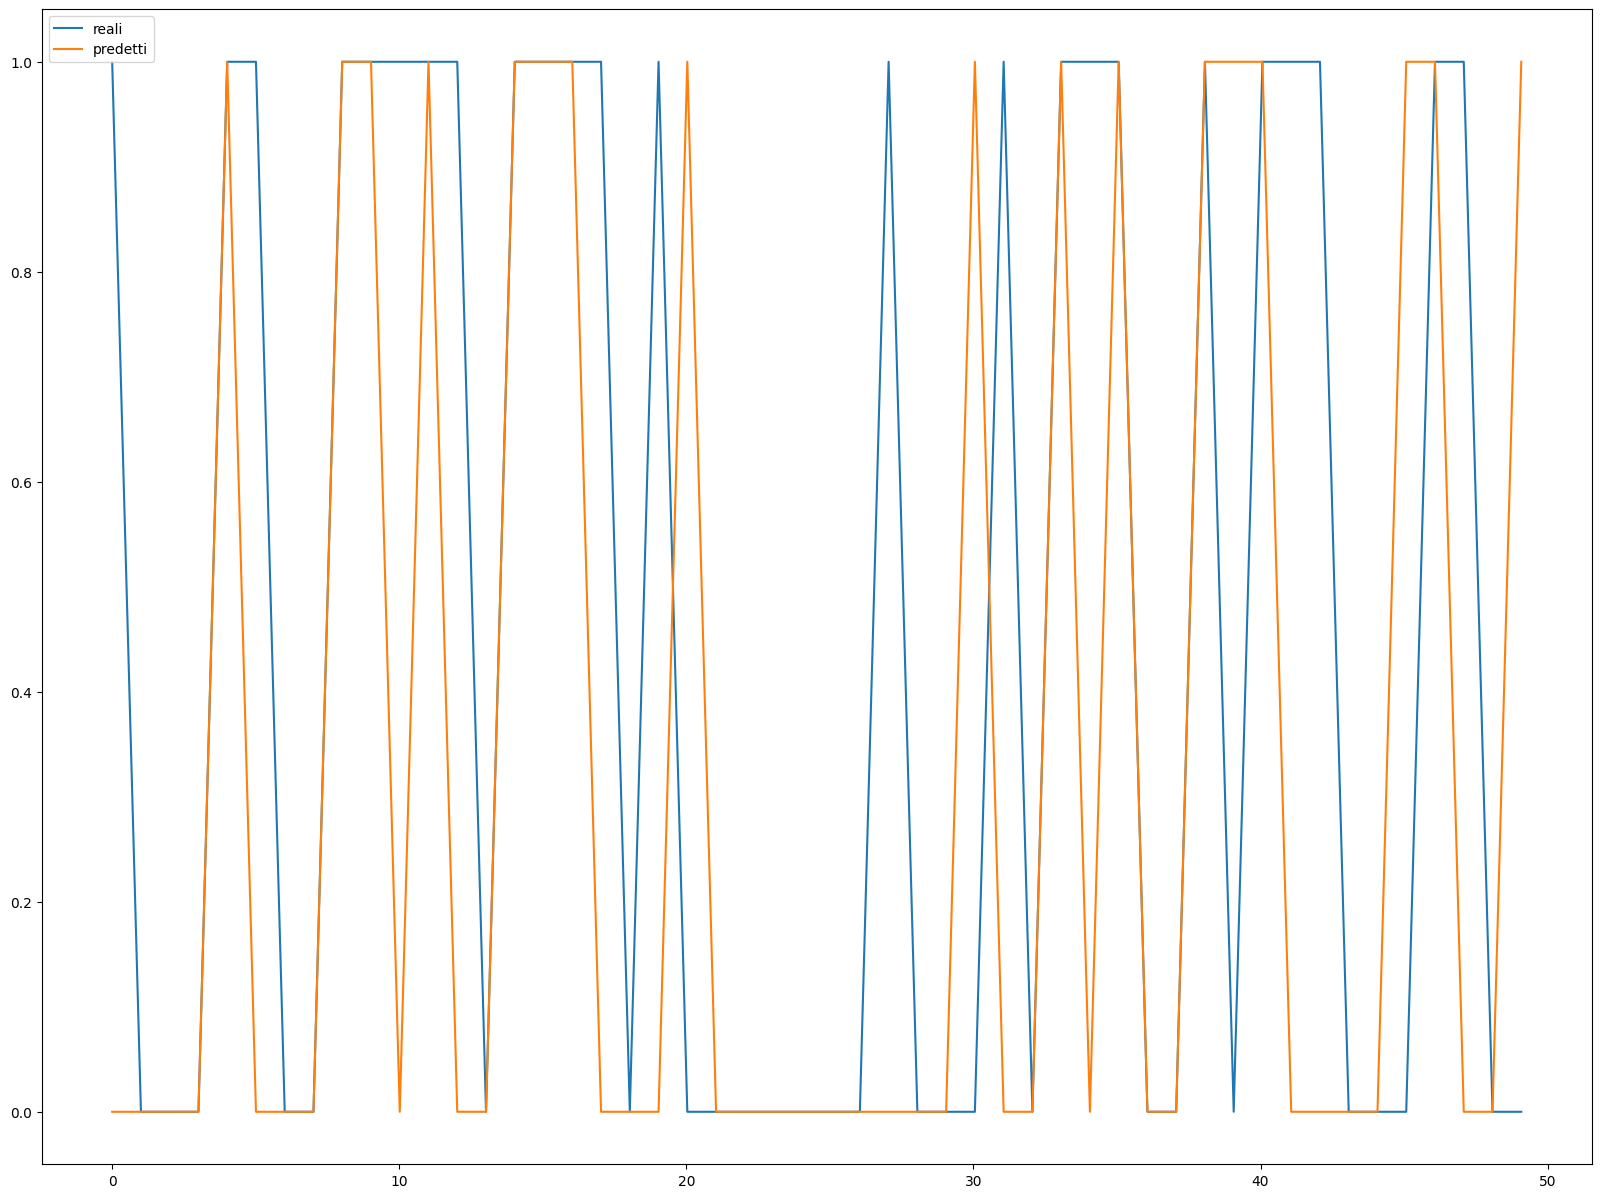

In [26]:
length = prediction_classes.shape[0] # 30
x = np.linspace(0,length,length)

plt.figure(figsize=(20,15))
plt.plot(x[:50], true_classes[:50], label='reali')
plt.plot(x[:50], prediction_classes[:50], label='predetti')
plt.legend(loc=2);

In [27]:
print(classification_report(true_classes, prediction_classes))

              precision    recall  f1-score   support

         0.0       0.65      0.72      0.68       305
         1.0       0.67      0.60      0.63       295

    accuracy                           0.66       600
   macro avg       0.66      0.66      0.66       600
weighted avg       0.66      0.66      0.66       600



# Confusion Matrix

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/cf_dog.jpg" width="800" align="center">

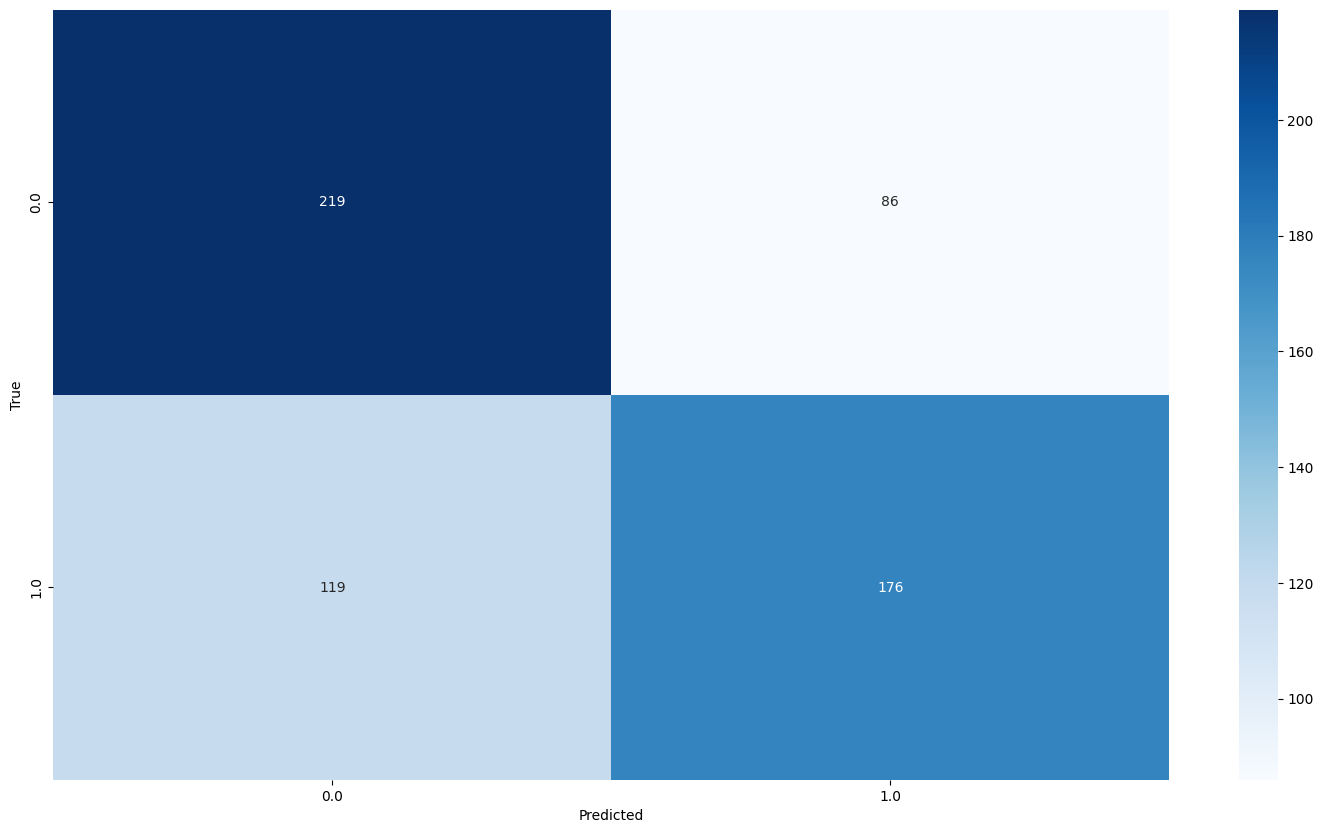

In [28]:
cm = pd.crosstab(true_classes,prediction_classes,
                 rownames = ['True'],
                 colnames = ['Predicted'])
plt.figure(figsize=(18,10))
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g');

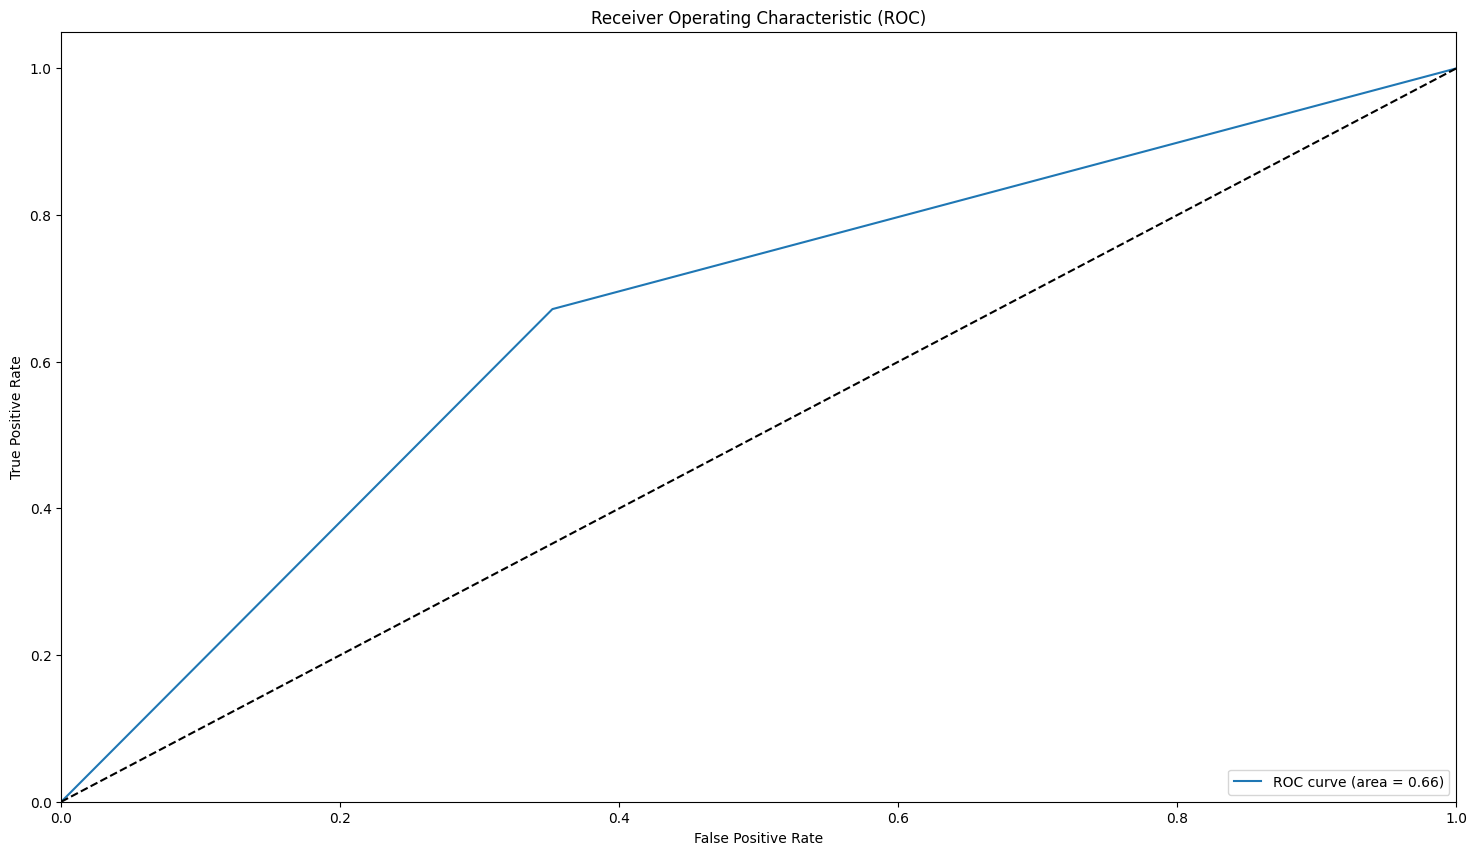

In [29]:
from sklearn.metrics import roc_curve, auc
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(18,10))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

plot_roc(true_classes,prediction_classes)

## Testing with New Data

In [30]:
#{'cats': 0, 'dogs': 1}

In [31]:
from google.colab import files
uploaded = files.upload()

Saving dog.jpg to dog.jpg


In [33]:
import numpy as np
from tensorflow.keras.preprocessing import image

classes = {0:"cat",
           1:"dog",}

# predicting images
path = 'dog.jpg'
#resize to the right input format
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
pred = model.predict(images)
print(pred)
pred = np.argmax(pred, axis=-1)[0]  ## Finalmente con la softmax!
res = classes[pred]
print("class= "+str(pred),", it's a:",res)

1/1 [==============================] - 0s 479ms/step
[[0.08000145 0.9199985 ]]
class= 1 , it's a: dog


In [34]:
model.save('test.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Convert tflite

In [35]:
import tensorflow as tf
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open('my_model.tflite', "wb").write(tfmodel)

13819440